<a href="https://colab.research.google.com/github/GaiaFL/Projet-Cassiopee/blob/main/KNN_gabriel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import ast
from sklearn.metrics import mean_squared_error
from math import sqrt
import gdown

# Load Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
url = 'https://docs.google.com/spreadsheets/d/1ko0Ly0EcOsKuEj-cCBOkM4CH2cfJKJeC/edit?usp=sharing'
file_id = url.split('/')[-2]

# URL de download do arquivo
download_url = f'https://drive.google.com/uc?id={file_id}'

# Caminho local para salvar o arquivo
output_path = '/content/drive/MyDrive/Prediction/Database.xlsx'

# Faz o download do arquivo do Google Drive
gdown.download(download_url, output_path, quiet=False)

# Lê o arquivo Excel com o pandas
data = pd.read_excel(output_path)

Downloading...
From: https://drive.google.com/uc?id=1ko0Ly0EcOsKuEj-cCBOkM4CH2cfJKJeC
To: /content/drive/MyDrive/Prediction/Database.xlsx
100%|██████████| 6.77k/6.77k [00:00<00:00, 18.6MB/s]


In [4]:
#path='/content/drive/MyDrive/Prediction/Database.xlsx'
data = pd.read_excel(output_path)
data = data.drop(data.columns[[1, 2]], axis=1)
data.columns = ["Coordinates", "1", "2", "3", "Average"]
data['Average'] = data['Average'].apply(pd.to_numeric)
data[['Tag', 'Coordinates']] = data.pop('Coordinates').str.split('-', n=1, expand=True)
data['Coordinates'] = data['Coordinates'].apply(ast.literal_eval).apply(pd.to_numeric)
print(data)

     1   2   3    Average                 Tag              Coordinates
0  -75 -73 -73 -73.666667  Forum Exit Maisel   [48.6246845, 2.4434301]
1  -68 -68 -66 -67.333333               Exit    [48.6246227, 2.443248]
2  -51 -53 -57 -53.666667        Exit Amph10    [48.624784, 2.4432668]
3  -46 -46 -46 -46.000000              B map   [48.6246377, 2.4430753]
4  -60 -61 -58 -59.666667    Exit Main Forum   [48.6249205, 2.4429265]
5  -56 -53 -56 -55.000000         Exit ABCDE   [48.6248764, 2.4427022]
6  -55 -55 -50 -53.333333       Exit Gymnase    [48.6249921, 2.442615]
7  -53 -53 -57 -54.333333               Nova   [48.6250615, 2.4427515]
8  -42 -39 -40 -40.333333             Door B   [48.6246393, 2.4430669]
9  -51 -49 -46 -48.666667           B middle    [48.6245008, 2.442969]
10 -59 -57 -56 -57.333333          Corner BD    [48.624341, 2.4428235]
11 -51 -49 -50 -50.000000           D middle   [48.6244057, 2.4426173]
12 -58 -57 -61 -58.666667         Corner ACD   [48.6245132, 2.4424125]
13 -48

<ipython-input-5-440d0c0f094f>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


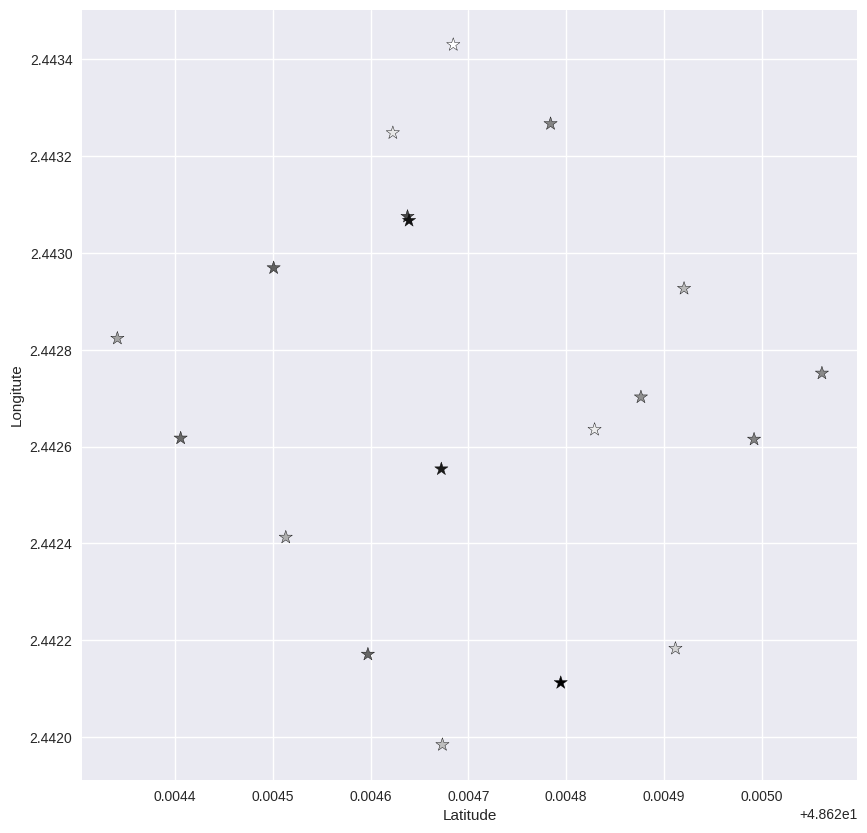

In [5]:
#Each star represents a point in the map, and the darker the star, the higher the average RSSI captured
plt.style.use('seaborn')
plt.figure(figsize = (10,10))
plt.scatter(data['Coordinates'].str[0], data['Coordinates'].str[1], c = data['Average'], marker= '*',s=100,edgecolors='black')
plt.xlabel("Latitude")
plt.ylabel("Longitute")
plt.show()

# Split Dataset

In [22]:
x = data['Average'].values.reshape(-1,1)
y = data['Coordinates'].values

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state = 0)

In [23]:
print('X_train\n', X_train)

print('X_test\n', X_test)

print('y_train\n', y_train)

print('y_test\n', y_test)

X_train
 [[-63.66666667]
 [-53.33333333]
 [-59.66666667]
 [-53.66666667]
 [-55.        ]
 [-49.66666667]
 [-48.66666667]
 [-54.33333333]
 [-68.33333333]
 [-50.        ]
 [-46.        ]
 [-73.66666667]
 [-38.        ]
 [-58.66666667]]
X_test
 [[-57.33333333]
 [-67.33333333]
 [-40.33333333]
 [-41.33333333]
 [-60.33333333]]
y_train
 [array([48.6249117,  2.4421828]) array([48.6249921,  2.442615 ])
 array([48.6249205,  2.4429265]) array([48.624784 ,  2.4432668])
 array([48.6248764,  2.4427022]) array([48.6245972,  2.4421708])
 array([48.6245008,  2.442969 ]) array([48.6250615,  2.4427515])
 array([48.624829 ,  2.4426351]) array([48.6244057,  2.4426173])
 array([48.6246377,  2.4430753]) array([48.6246845,  2.4434301])
 array([48.6247944,  2.4421121]) array([48.6245132,  2.4424125])]
y_test
 [array([48.624341 ,  2.4428235]) array([48.6246227,  2.443248 ])
 array([48.6246393,  2.4430669]) array([48.6246723,  2.4425536])
 array([48.6246734,  2.441984 ])]


#KNN Algorithm

In [8]:
class KnnLocalizer:

    """ KNN Regression Class for indoor localization using a 3-dimensional label space
        e.g.  Longitude, Latitude, and Floor

    Attributes:
        features - training data features - Average RSSI
        labels -  training data labels - Coordinates
        k (int) number of nearest neighbors

    """

    def __init__(self, features, labels, k=3):

        self.features = np.array(features)
        self.labels = np.array(labels)
        self.k = k

    @staticmethod
    def euclidean_distance(array1, array2): #Calculate the diference between each RSSI

        """ Euclidean distance function without squareroot taken for efficiency

		Args:
			Two arrays of equal length

		Returns:
			Distance squared between RSSI1 and RSSI2
		"""

        distance = np.sum((array1-array2)**2)
        return distance

    @staticmethod
    def timsort(array, element):

        """ Sort method based on Python's sort() function that sorts tuples in descending order

        Args:
            array (array or list of tuples) array of tuples containing distance and label
            element (Int) the index of the element within tuple that is used to sort tuples

        Returns:
            Array of tuples sorted in descending order at index given by element
        """

        array.sort(key=lambda tup: tup[element])
        return array


    def knn_regression(self, instance):

        """ KNN regression function modified to return regression predictions
         of 3-dimensional labelspace: (RSSI, logitude, latitude).

        Args:
            Test_features (array) test RSSI for which to predict location

        Returns:
            An array containing coordinate prediction
        """
        temp_results = []
        for i in range(len(self.features)):
            
            RSSI = self.euclidean_distance(instance, self.features[i])
            temp_results.append((self.labels[i], RSSI)) #each localisation with the difference of RSSI   
        sorted_distances = self.timsort(temp_results, 1)
        return np.stack(sorted_distances[0][0], axis=0) #return localisation with minimum RSSI 

    def fit_predict(self, test_data):

        """ KNN Localizer prediction function

        Args:
        	test_data (array) test RSSI

        Returns:
        	List of arrays containing coordinate predictions
        """

        predictions = []
        for sample in test_data:
            predictions.append(self.knn_regression(sample))
        return predictions

In [9]:
localizer = KnnLocalizer(X_train, y_train, 1)
new_predictions = localizer.fit_predict(X_test) 
print(new_predictions)

[array([48.6245132,  2.4424125]), array([48.624829 ,  2.4426351]), array([48.6247944,  2.4421121]), array([48.6247944,  2.4421121]), array([48.6249205,  2.4429265])]


# Comparison of Results

In [19]:
#Needs to compare the predictions with the test dataset
new_predictions = np.asarray(new_predictions)
print('Predictions made:\n', new_predictions)
print('Testing values\n', y_test)
n = len(y_test)

new_predictions_2 = np.split(new_predictions, n)
#print(new_predictions_2)

y_test_equalized = [arr.flatten() for arr in y_test]
print('Testing values equals\n',y_test_equalized)

new_predictions_equalized = [arr.flatten() for arr in new_predictions]
print('Predictions made equals:\n',new_predictions_equalized)

mse2 = mean_squared_error(y_test_equalized, new_predictions_2)
print('MSE:\n', mse2)
 #Gives error, improves it pls

Predictions made:
 [[48.6245132  2.4424125]
 [48.624829   2.4426351]
 [48.6247944  2.4421121]
 [48.6247944  2.4421121]
 [48.6249205  2.4429265]]
Testing values
 [array([48.624341 ,  2.4428235]) array([48.6246227,  2.443248 ])
 array([48.6246393,  2.4430669]) array([48.6246723,  2.4425536])
 array([48.6246734,  2.441984 ])]
Testing values equals
 [array([48.624341 ,  2.4428235]), array([48.6246227,  2.443248 ]), array([48.6246393,  2.4430669]), array([48.6246723,  2.4425536]), array([48.6246734,  2.441984 ])]
Predictions made equals:
 [array([48.6245132,  2.4424125]), array([48.624829 ,  2.4426351]), array([48.6247944,  2.4421121]), array([48.6247944,  2.4421121]), array([48.6249205,  2.4429265])]


ValueError: ignored

In [25]:

#Needs to compare the predictions with the test dataset
new_predictions = np.asarray(new_predictions)

y_test_div = np.concatenate(y_test)
new_predictions_div = np.concatenate(new_predictions)

print(new_predictions_div)
print(y_test_div)

mse = mean_squared_error(y_test_div, new_predictions_div)
print(mse) 

 #I tried to concatenate the two arrays but I don't think the result is sufficient

[48.6245132  2.4424125 48.624829   2.4426351 48.6247944  2.4421121
 48.6247944  2.4421121 48.6249205  2.4429265]
[48.624341   2.4428235 48.6246227  2.443248  48.6246393  2.4430669
 48.6246723  2.4425536 48.6246734  2.441984 ]
2.711674309998789e-07


In [ ]:
2.711674309998789e-07
